In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import random
import numpy as np

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Limpieza de Datos con Pandas

### Limpieza de datos

In [3]:
import os
import pandas as pd

def create_dataframe(root_path):
    filepaths = []
    labels = []

    # Verificamos que la ruta exista
    if not os.path.exists(root_path):
        print(f"Error: La ruta {root_path} no existe. Verifica la dirección.")
        return None

    # Recorrer las carpetas (clases)
    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)
        
        # Solo entramos si es una carpeta (ej: 'fractured', 'not_fractured')
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                # Filtrar solo imágenes
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    fpath = os.path.join(folder_path, file)
                    filepaths.append(fpath)
                    labels.append(folder)
    
    # Crear y retornar el DataFrame
    df = pd.DataFrame({
        'filepath': filepaths,
        'label': labels
    })
    return df

# Rutas a los datasets
train_dir = 'data/Bone_Fracture_Binary_Classification/train' 
val_dir = 'data/Bone_Fracture_Binary_Classification/val' 
test_dir = 'data/Bone_Fracture_Binary_Classification/test'  

# Crear los DataFrames
train_df = create_dataframe(train_dir)
val_df = create_dataframe(val_dir)
test_df = create_dataframe(test_dir)

# Verificación rápida
print(f"Train data: {len(train_df)} imágenes")
print(f"Val data: {len(val_df)} imágenes")
print(f"Test data: {len(test_df)} imágenes")
print(train_df.head()) # Para ver que las columnas 'filepath' y 'label' existen

Train data: 9246 imágenes
Val data: 829 imágenes
Test data: 506 imágenes
                                            filepath      label
0  data/Bone_Fracture_Binary_Classification/train...  fractured
1  data/Bone_Fracture_Binary_Classification/train...  fractured
2  data/Bone_Fracture_Binary_Classification/train...  fractured
3  data/Bone_Fracture_Binary_Classification/train...  fractured
4  data/Bone_Fracture_Binary_Classification/train...  fractured


In [4]:
# Definimos la clase del Dataset
class BoneFractureDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame con columnas 'filepath' y 'label'.
            transform (callable, optional): Transformaciones (resize, normalize, etc).
        """
        self.dataframe = dataframe
        self.transform = transform
        
        # Mapeamos etiquetas de texto a números (ej: 'fractured': 1, 'normal': 0)
        # Ajusta esto según los nombres reales de tus carpetas
        self.label_map = {label: idx for idx, label in enumerate(dataframe['label'].unique())}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 1. Obtener la ruta de la imagen
        img_path = self.dataframe.iloc[idx]['filepath']
        
        # 2. Cargar imagen (convertir a gris para LeNet)
        image = Image.open(img_path).convert('L') 
        
        # 3. Obtener etiqueta numérica
        label_str = self.dataframe.iloc[idx]['label']
        label = self.label_map[label_str]
        
        # 4. Aplicar transformaciones
        if self.transform:
            image = self.transform(image)
            
        # Retornamos la imagen y su etiqueta (como tensor flotante para la loss function)
        return image, torch.tensor(label, dtype=torch.float32)


In [5]:
# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((32, 32)), # Tamaño clásico LeNet
    transforms.ToTensor(),       # Convierte a Tensor y escala a [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalización estándar (-1 a 1)
])

# Instanciar el Dataset usando el DataFrame 'val_df' que creamos antes
# (Asumiendo que hiciste lo mismo para un 'train_df')
train_dataset = BoneFractureDataset(train_df, transform=transform)
val_dataset = BoneFractureDataset(val_df, transform=transform)
test_dataset = BoneFractureDataset(test_df, transform=transform)

# Crear los DataLoaders (esto es lo que itera sobre los datos)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
from PIL import Image
from tqdm import tqdm # Barra de progreso

def clean_dataframe(df):
    indices_to_drop = []
    print(f"Verificando {len(df)} imágenes...")
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            # Intentamos abrir la imagen completamente
            img = Image.open(row['filepath'])
            img.load() # Forzamos la lectura de los datos
        except OSError:
            print(f"Imagen corrupta encontrada y eliminada: {row['filepath']}")
            indices_to_drop.append(idx)
        except Exception as e:
            print(f"Error en imagen {row['filepath']}: {e}")
            indices_to_drop.append(idx)
            
    # Eliminamos las filas malas
    return df.drop(indices_to_drop)

# Limpiamos el dataframe de entrenamiento
train_df = clean_dataframe(train_df)
test_df = clean_dataframe(test_df)
val_df = clean_dataframe(val_df)

# IMPORTANTE: Recrear el Dataset y el DataLoader con el dataframe limpio
train_dataset = BoneFractureDataset(train_df, transform=transform)
val_dataset = BoneFractureDataset(val_df, transform=transform)
test_dataset = BoneFractureDataset(test_df, transform=transform)

# Crear los DataLoaders (esto es lo que itera sobre los datos)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Limpieza completada. Puedes entrenar ahora.")

Verificando 9246 imágenes...


 53%|█████▎    | 4884/9246 [00:07<00:04, 905.86it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004143.jpg


 60%|██████    | 5577/9246 [00:07<00:03, 1117.19it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg


 65%|██████▍   | 6006/9246 [00:08<00:03, 865.37it/s] 

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004134.jpg


 67%|██████▋   | 6180/9246 [00:08<00:04, 741.74it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004308.jpg


 92%|█████████▏| 8551/9246 [00:11<00:00, 1089.92it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004149.jpg


100%|██████████| 9246/9246 [00:11<00:00, 779.82it/s] 


Verificando 506 imágenes...


 54%|█████▍    | 273/506 [00:00<00:00, 327.23it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004143.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004347.jpg


 61%|██████    | 308/506 [00:00<00:00, 309.91it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004134.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004308.jpg


 97%|█████████▋| 491/506 [00:01<00:00, 211.85it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004148.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004149.jpg


100%|██████████| 506/506 [00:02<00:00, 245.71it/s]


Verificando 829 imágenes...


 50%|████▉     | 413/829 [00:01<00:01, 277.79it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004143.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004347.jpg


 59%|█████▉    | 491/829 [00:01<00:01, 258.50it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004134.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004308.jpg


 97%|█████████▋| 803/829 [00:02<00:00, 359.12it/s]

Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004148.jpg
Imagen corrupta encontrada y eliminada: data/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004149.jpg


100%|██████████| 829/829 [00:03<00:00, 268.16it/s]

Limpieza completada. Puedes entrenar ahora.


## LeNet5: Una Arquitectura Clásica de Red Neuronal Convolucional

In [8]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # C1: 1 canal de entrada (Escala de grises) -> 6 canales de salida
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        # S2: Pooling
        self.avgpool1 = nn.AvgPool2d(2, 2)
        # C3: 6 -> 16
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # S4: Pooling
        self.avgpool2 = nn.AvgPool2d(2, 2)
        
        # C5: Flatten. 
        # Si la imagen entra de 32x32, después de las convulsiones queda de 5x5.
        # 16 canales * 5 * 5 = 400 entradas
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # FC6
        self.fc2 = nn.Linear(120, 84)

        # Ahora: 
        self.fc3 = nn.Linear(84, 1)  # <-- Solo 1 neurona para Binary Classification

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.avgpool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.avgpool2(x)
        
        # Aplanamos (Flatten)
        x = x.view(x.size(0), -1) 

        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))

        x = self.fc3(x)  # Retorna el logit (sin sigmoide)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)

# Como recreamos el modelo, debemos recrear el optimizador (para que coja los nuevos parámetros)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Modelo LeNet5 actualizado para clasificación binaria (1 salida).")

Modelo LeNet5 actualizado para clasificación binaria (1 salida).


In [12]:
# Hiperparámetros
num_epochs = 25
learning_rate = 0.001

# Definir la función de pérdida y el optimizador
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# %% ENTRENAMIENTO
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # VALIDACIÓN
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Guardar métricas
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {avg_train_loss:.4f} | '
          f'Val Loss: {avg_val_loss:.4f} | '
          f'Val Acc: {val_acc:.2f}%')


/opt/anaconda3/lib/python3.13/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/25] | Train Loss: 0.0038 | Val Loss: 0.0771 | Val Acc: 98.42%
Epoch [2/25] | Train Loss: 0.0004 | Val Loss: 0.1041 | Val Acc: 98.06%
Epoch [3/25] | Train Loss: 0.0031 | Val Loss: 0.2181 | Val Acc: 95.26%
Epoch [4/25] | Train Loss: 0.0350 | Val Loss: 0.1026 | Val Acc: 97.93%
Epoch [5/25] | Train Loss: 0.0021 | Val Loss: 0.1153 | Val Acc: 97.57%
Epoch [6/25] | Train Loss: 0.0016 | Val Loss: 0.0927 | Val Acc: 98.30%
Epoch [7/25] | Train Loss: 0.0004 | Val Loss: 0.0987 | Val Acc: 98.18%
Epoch [8/25] | Train Loss: 0.0002 | Val Loss: 0.1024 | Val Acc: 98.06%
Epoch [9/25] | Train Loss: 0.0002 | Val Loss: 0.1040 | Val Acc: 97.93%
Epoch [10/25] | Train Loss: 0.0001 | Val Loss: 0.1073 | Val Acc: 97.93%
Epoch [11/25] | Train Loss: 0.0001 | Val Loss: 0.1037 | Val Acc: 98.06%
Epoch [12/25] | Train Loss: 0.0001 | Val Loss: 0.1072 | Val Acc: 97.93%
Epoch [13/25] | Train Loss: 0.0001 | Val Loss: 0.1101 | Val Acc: 97.93%
Epoch [14/25] | Train Loss: 0.0001 | Val Loss: 0.1120 | Val Acc: 97.93%
E

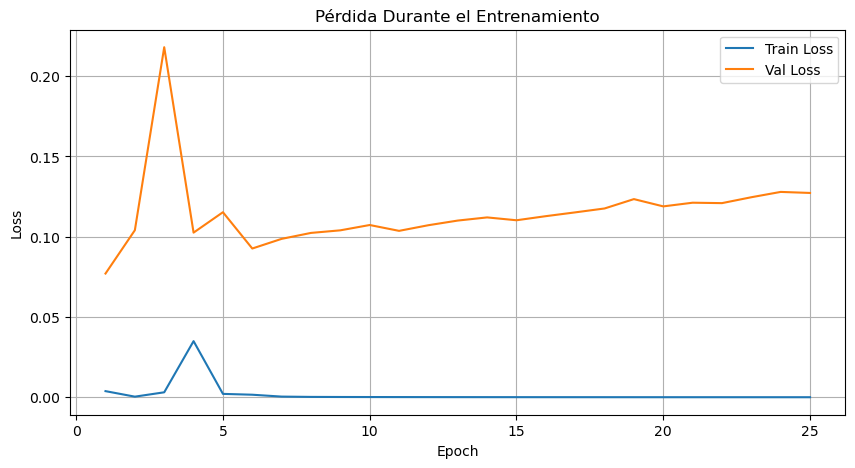

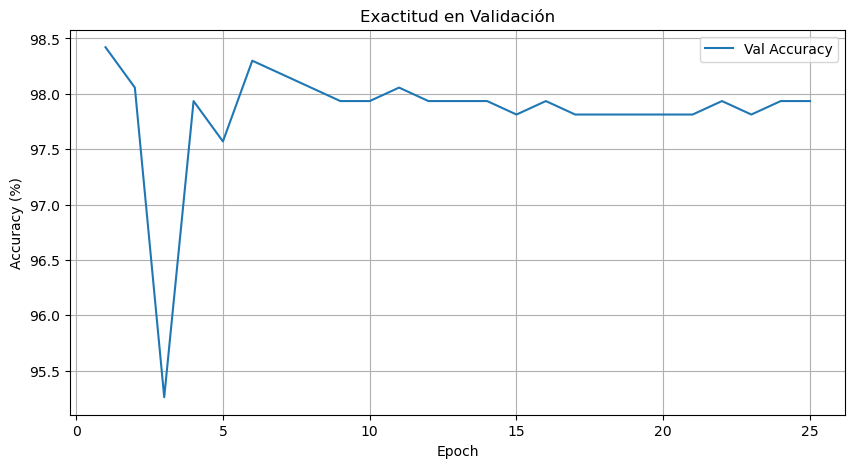

In [13]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.title("Pérdida Durante el Entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.title("Exactitud en Validación")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()